In [1]:
import os
import sys
import numpy as np
import pandas as pd
import importlib
from shutil import rmtree, copy, copytree
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['DejaVu Serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.size'] = 30
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = True
rcParams['mathtext.default'] = 'regular'
rcParams['text.usetex'] = False

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import (PercentileInterval, LogStretch, PowerStretch, ManualInterval, ZScaleInterval, ImageNormalize)
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

from casatasks import listobs, split, clearcal, delmod, rmtables, setjy, gaincal, bandpass, applycal, tclean, flagdata, ft, fixvis, phaseshift, casalog, mstransform, exportfits
from casatools import componentlist, msmetadata, imager, ms, table, linearmosaic

In [2]:
lm = linearmosaic()

lm.setlinmostype('optimal')

True

In [5]:
basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-03-07/'

input_msfiles = [file for file in os.listdir(basepath) if file.endswith('_base.ms')]

input_msfiles_sorted = sorted(input_msfiles, key=lambda fname: float(fname.split("_ra")[1].split("_")[0]))

input_msfiles_fullpath = [os.path.join(basepath, i) for i in input_msfiles_sorted]

input_images = [file for file in os.listdir(basepath) if file.endswith('nitr10000.image')]

input_images_sorted = sorted(input_images, key=lambda fname: float(fname.split("_ra")[1].split("_")[0]))

input_images_fullpath = [os.path.join(basepath, i) for i in input_images_sorted]

print(len(input_images_sorted))

pb_images = [file for file in os.listdir(basepath) if file.endswith('nitr10000.pb')]

pb_images_sorted = sorted(pb_images, key=lambda fname: float(fname.split("_ra")[1].split("_")[0]))

pb_images_fullpath = [os.path.join(basepath, i) for i in pb_images_sorted]

print(len(pb_images_sorted))


4
4


In [4]:
all_mean_ras = []
all_mean_decs = []

print(f'Finding phasecenter across {len(input_msfiles)} MS files...')

for msfile in input_msfiles_sorted:
    msmd = msmetadata()
    msmd.open(os.path.join(basepath, msfile))

    # Get the total number of fields
    num_fields = msmd.nfields()
    field_names = msmd.fieldnames()

    # Retrieve phase centers for all fields
    phase_centers = []
    for field_id in range(num_fields):
        pc = msmd.phasecenter(field_id)
        ra = pc['m0']['value']  # RA in radians
        dec = pc['m1']['value']  # Dec in radians
        phase_centers.append((ra, dec))

    # Convert to degrees for easier interpretation
    rad2deg = lambda x: ((x * 180.0 / np.pi) + 360) % 360  
    phase_centers_deg = [(rad2deg(ra), rad2deg(dec)) for ra, dec in phase_centers]

    # Calculate the geometric mean center (central coordinate)
    center_ra = np.mean([coord[0] for coord in phase_centers_deg])
    center_dec = np.mean([coord[1] for coord in phase_centers_deg])
    all_mean_ras.append(center_ra)
    all_mean_decs.append(center_dec)

ra_mean_deg = np.mean(all_mean_ras)
dec_mean_deg = np.mean(all_mean_decs)

center_coord = SkyCoord(ra_mean_deg, dec_mean_deg, unit='deg')

ra_fixed = f'{round(center_coord.ra.hms.h)}h{round(center_coord.ra.hms.m)}m{round(center_coord.ra.hms.s, 4)}s'
dec_fixed = f'{round(center_coord.dec.dms.d)}d{round(center_coord.dec.dms.m)}m{round(center_coord.dec.dms.s, 4)}s'

phasecenter = f'J2000 {ra_fixed} {dec_fixed}'

print('\n')
print(f'Phase Center (deg): {ra_mean_deg, dec_mean_deg}')
print(f'Phase Center (hms): {phasecenter}')
print('\n')

Finding phasecenter across 4 MS files...


Phase Center (deg): (74.85915331805812, 45.268476132384045)
Phase Center (hms): J2000 4h59m26.1968s 45d16m6.5141s




In [5]:
first_ms = input_msfiles[0]
last_ms = input_msfiles[-1]
mosimagename = f"mosaic_{first_ms.split('_')[0]}_{last_ms.split('_')[0]}_ra{first_ms.split('_')[1][3:]}_{last_ms.split('_')[1][3:]}_dec{first_ms.split('_')[2][3:]}_{last_ms.split('_')[2][3:]}.linmos"
weightmosname = f"weight_{first_ms.split('_')[0]}_{last_ms.split('_')[0]}_ra{first_ms.split('_')[1][3:]}_{last_ms.split('_')[1][3:]}_dec{first_ms.split('_')[2][3:]}_{last_ms.split('_')[2][3:]}.weightlinmos"

lm.defineoutputimage(nx=9600, ny=4800, cellx='3arcsec', celly='3arcsec', \
        imagecenter=phasecenter, #01h37m41.299431s 33d09m35.132990s', #set to calibrator coordinates
        outputimage=os.path.join(basepath, f'{mosimagename}'), \
        outputweight=os.path.join(basepath, f'{weightmosname}'))

lm.makemosaic(images=input_images_fullpath, weightimages=pb_images_fullpath, imageweighttype=0, weighttype=1)
print('Mosaic done!')
print('\n')

lm.saultweightimage(os.path.join(basepath, f'{mosimagename.split(".")[0]}_sault.linmos'))
print('Sault Weighted Image Done!')
print('\n')


Mosaic done!


Sault Weighted Image Done!




In [6]:
print(mosimagename)

mosaic_2025-03-07T01:49:09_2025-03-07T01:59:28_ra74.2_76.8_dec+45.3_+45.3.linmos


In [ ]:
# Load NVSS catalog
sys.path.insert(0, '/data/jfaber/dsa110-contimg/sandbox/scripts')
import make_skymodel_cl_mf
importlib.reload(make_skymodel_cl_mf)
from make_skymodel_cl_mf import make_skymodel

# Number of bright sources to include in the sky model
top_n = 1000

print(f'Generating a sky model with the top {top_n} brightest NVSS sources...')

nvss_catalog = make_skymodel(basepath, , fieldname=fieldname_image, top_n=top_n, pbfrac=0.5)

catalog = nvss_catalog
nvss_flux_col = "S1.4"  # NVSS flux column
catalog = catalog[~catalog[nvss_flux_col].mask]  # Remove masked (NaN) values
catalog_sorted_table = catalog[np.argsort(catalog[nvss_flux_col].data)[::-1]]  # Sort descending by flux
catalog_top_sources = catalog_sorted_table[:top_n]
#catalog = catalog[catalog['S1.4'] > 10]  # Filter sources brighter than 10 mJy

# Convert NVSS RA/Dec to pixel coordinates
nvss_coords = SkyCoord(ra=catalog_top_sources['RAJ2000'], dec=catalog_top_sources['DEJ2000'], frame='icrs', unit=(u.hourangle, u.deg))

# Extract RA, Dec, and add constant frequency and Stokes
ra_deg = nvss_coords.ra.deg
dec_deg = nvss_coords.dec.deg
freq_array = [freq_val] * len(ra_deg)  # Repeat frequency for all sources
stokes_array = [stokes_val] * len(ra_deg)  # Repeat Stokes for all sources

# Pass all 4 axes to wcs.world_to_pixel
wcs_2d_coords_x, wcs_2d_coords_y = wcs_2d.world_to_pixel_values(ra_deg, dec_deg)

Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


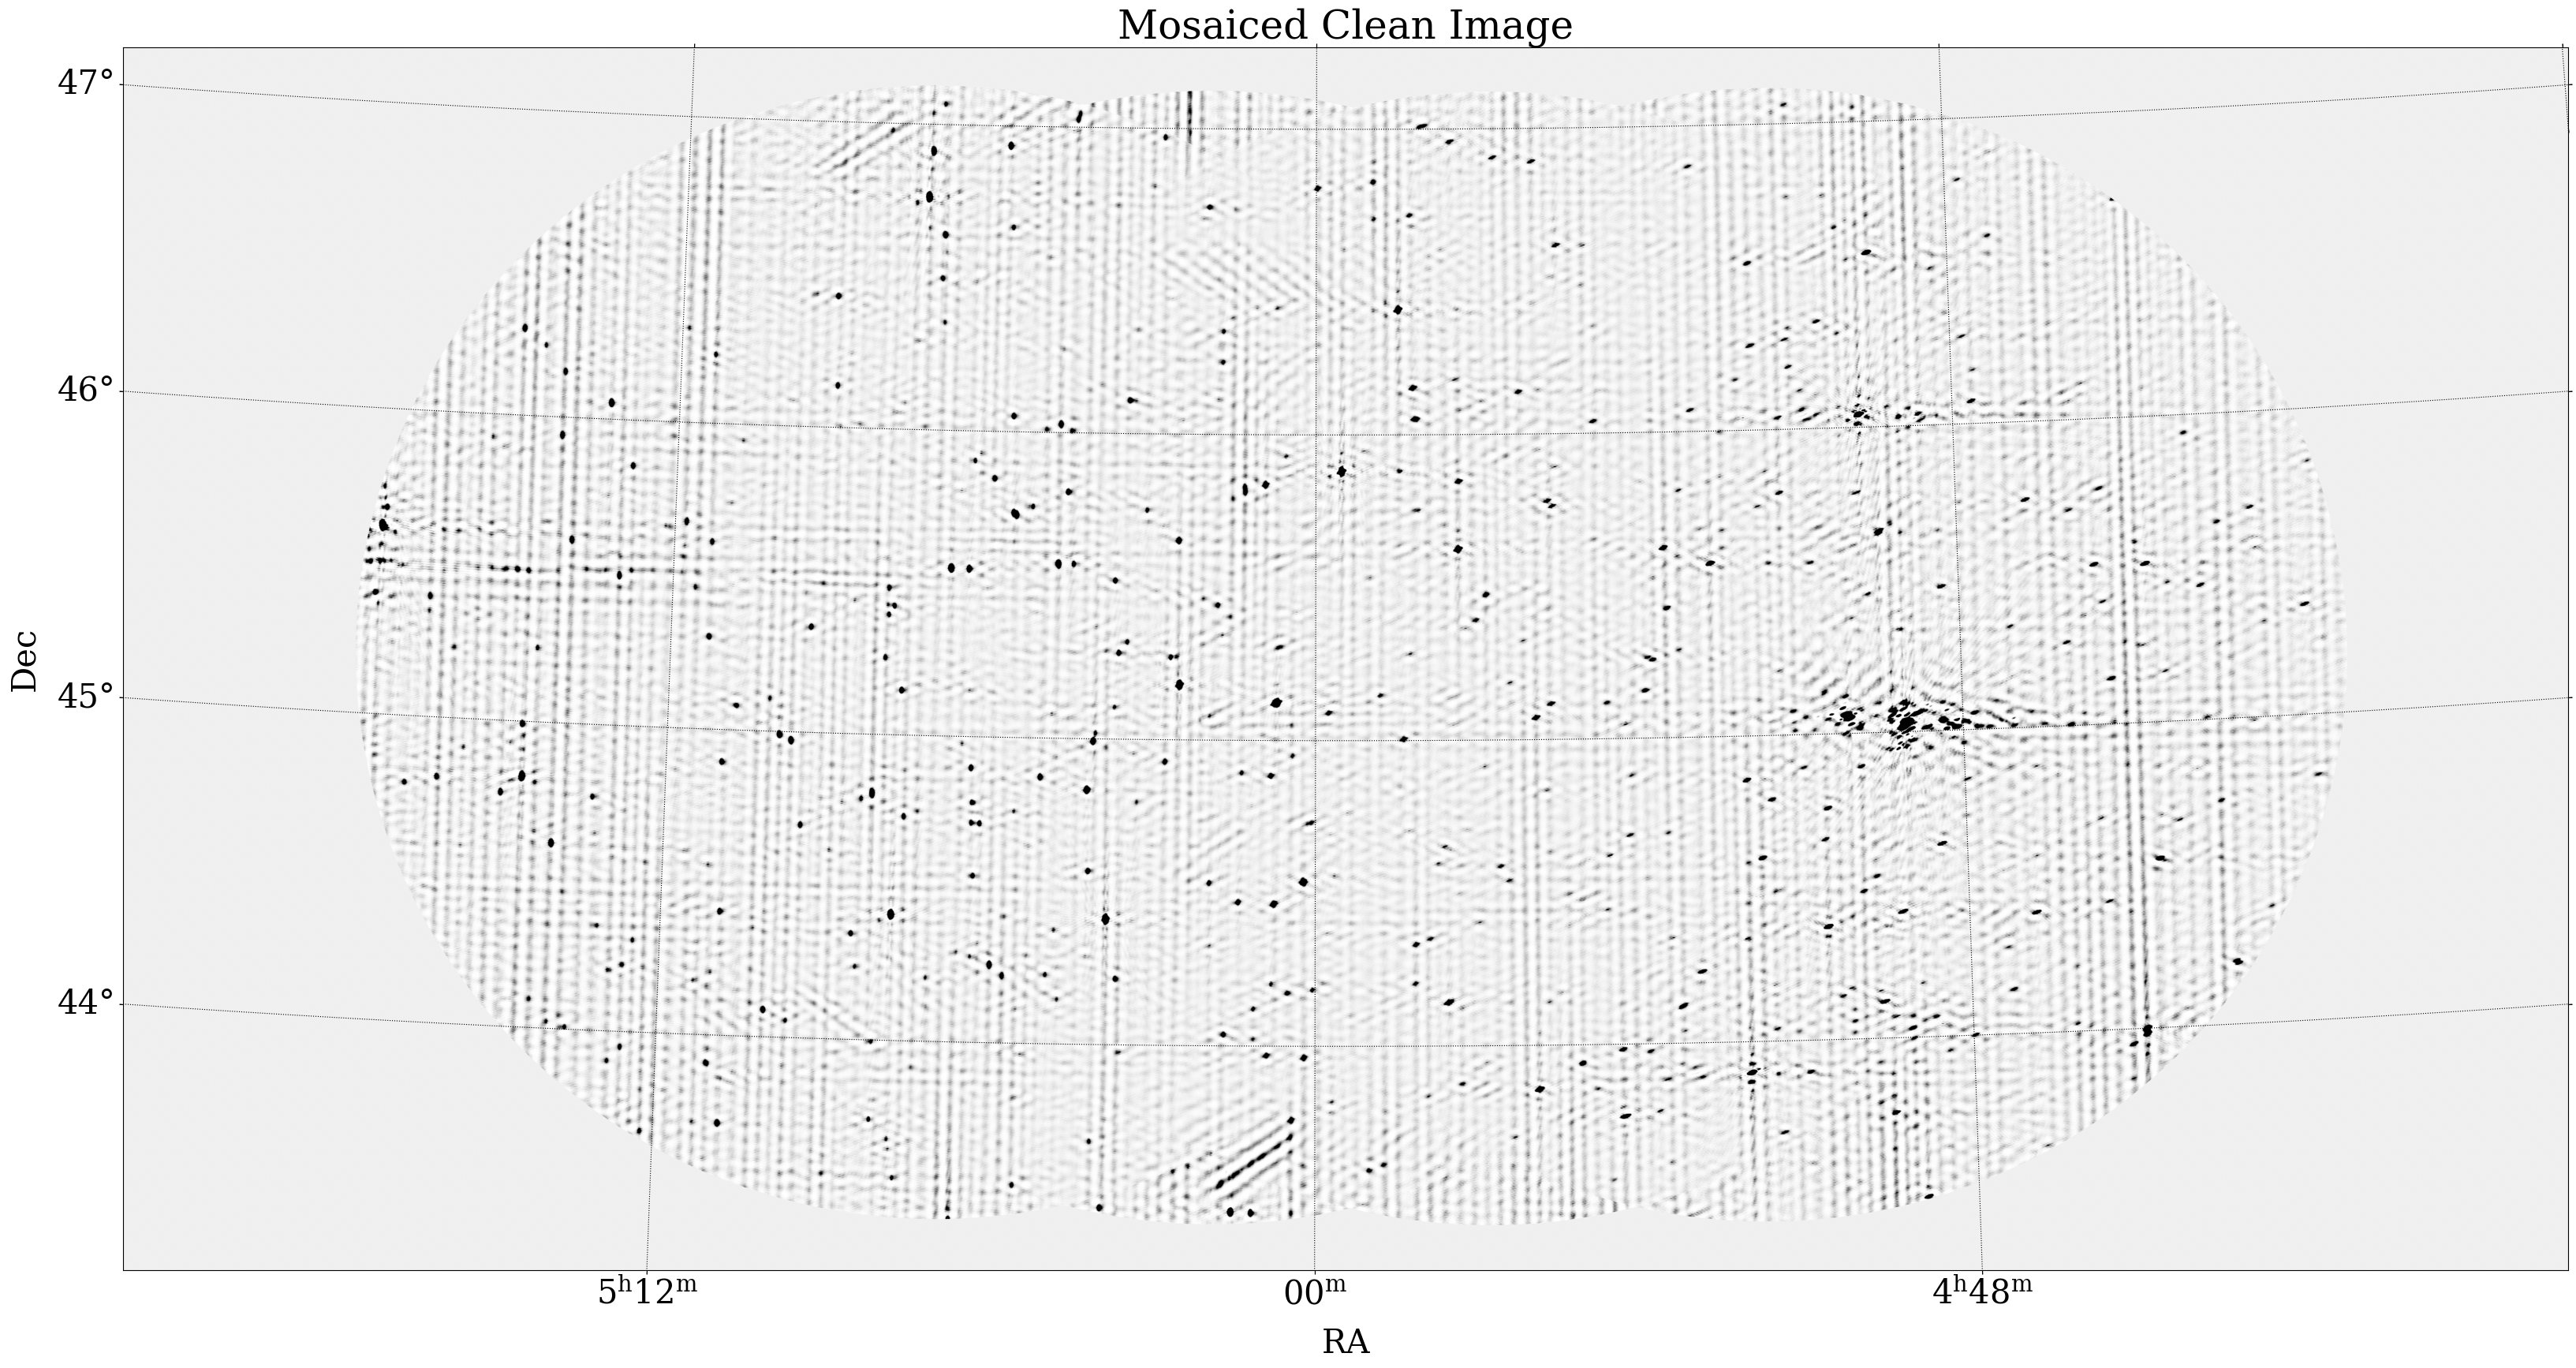

In [8]:
#if os.path.exists(os.path.join(basepath, mosimagename) + '.fits'):
#    os.remove(os.path.join(basepath, mosimagename) + '.fits')
    
#exportfits(os.path.join(basepath, mosimagename), os.path.join(basepath, mosimagename) + '.fits')
# Load the FITS image
#for fieldname in field_names:
fits_file = os.path.join(basepath, 'mosaic_2025-03-07T01:49:09_2025-03-07T01:59:28_ra74.2_76.8_dec+45.3_+45.3.linmos.fits') #os.path.join(basepath, mosimagename) + '.fits'
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (40, 40))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=4))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Mosaiced Clean Image')
plt.grid(color='k', ls='dotted')
#fig.savefig(os.path.join(basepath, f'{mosimagename}') + '.pdf')

In [4]:
#if os.path.exists(os.path.join(basepath, mosimagename) + '.fits'):
#    os.remove(os.path.join(basepath, mosimagename) + '.fits')
    
#exportfits(os.path.join(basepath, mosimagename), os.path.join(basepath, mosimagename) + '.fits')
# Load the FITS image
#for fieldname in field_names:
fits_file = os.path.join(basepath, 'mosaic_2025-03-07T01:49:09_2025-03-07T01:59:28_ra74.2_76.8_dec+45.3_+45.3.linmos.fit')
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (40, 40))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=4))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Mosaiced Clean Image')
plt.grid(color='k', ls='dotted')
fig.savefig(os.path.join(basepath, f'{mosimagename}') + '.pdf')

NameError: name 'basepath' is not defined

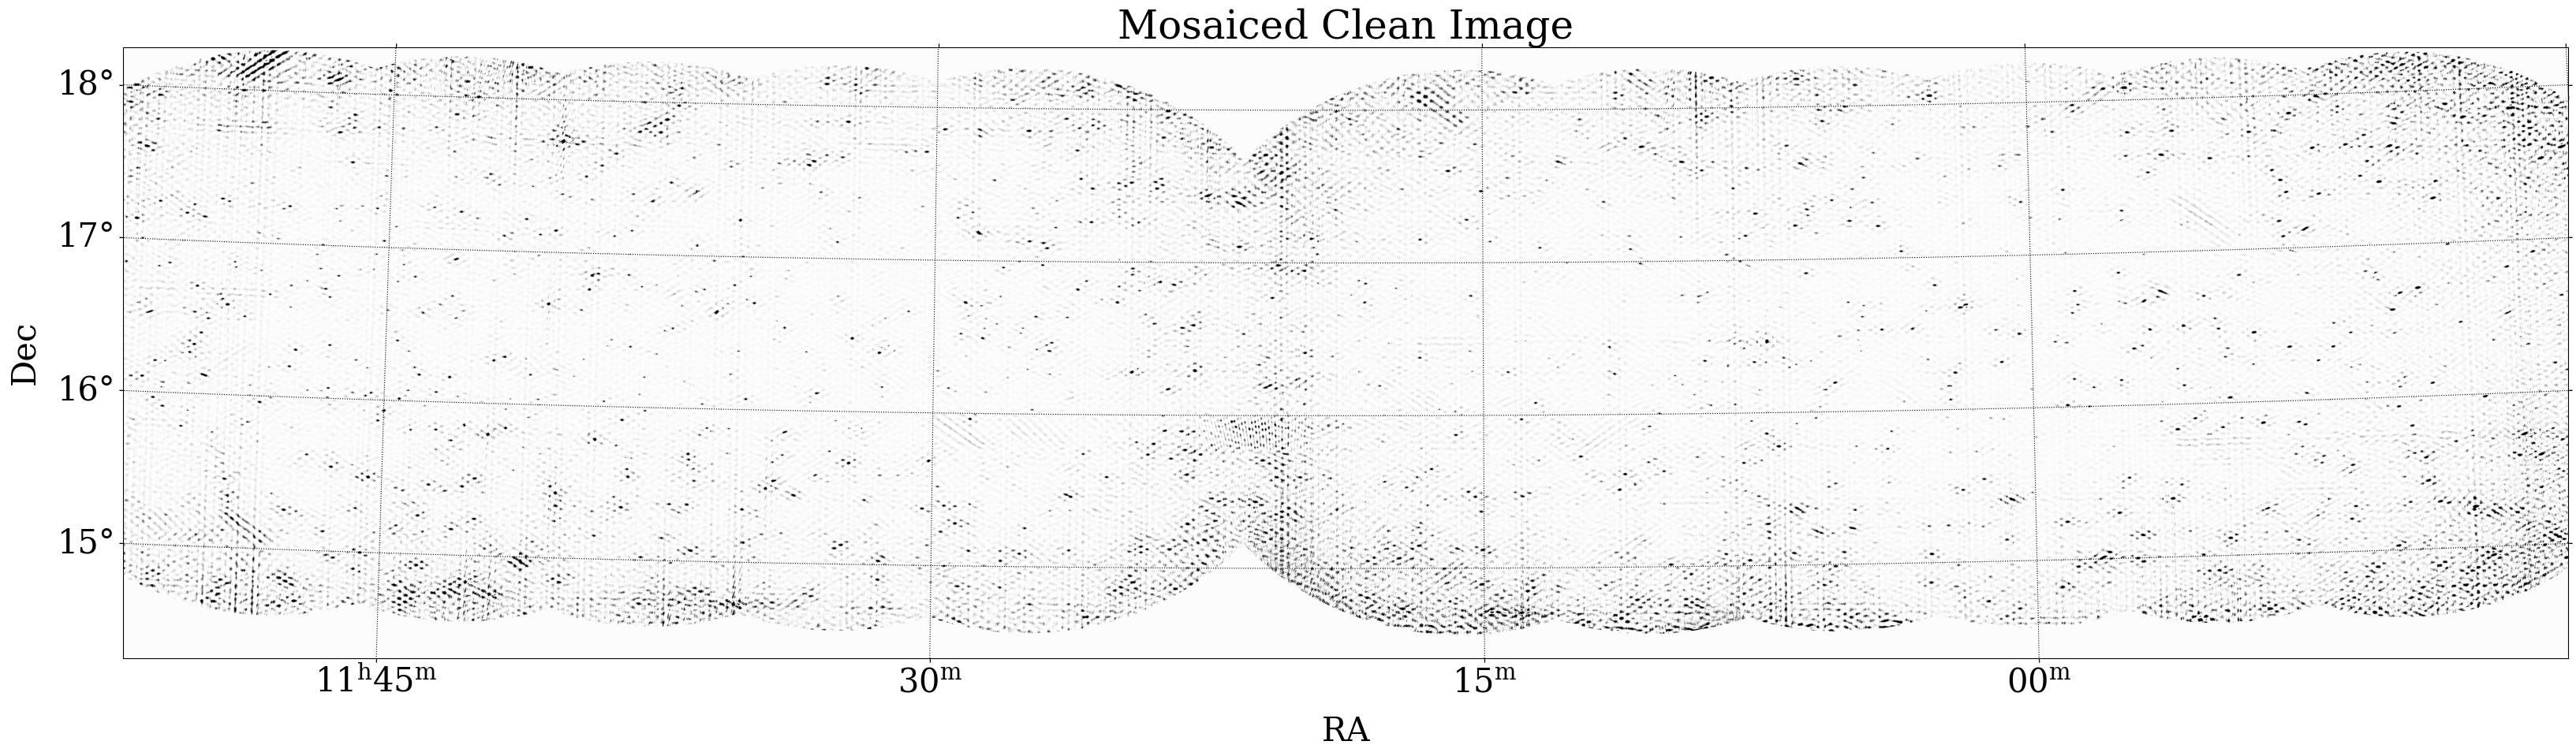

In [27]:
# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (40, 40))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=6))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Mosaiced Clean Image')
plt.grid(color='k', ls='dotted')
fig.savefig(os.path.join(basepath, f'{mosimagename}') + '.pdf')